In [5]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import pandas as pd
import os
import matplotlib.pyplot as plt

In [9]:
# Đọc file CSV và ánh xạ các lớp
df = pd.read_csv("D:/Study/Summer 2024/AIL303m/mini project/archive/db_lisa_tiny/annotations.csv")
df = df.sample(frac=1)  # Shuffle

In [10]:
# Đường dẫn đầy đủ
def full_path(x):
    return os.path.join("D:/Study/Summer 2024/AIL303m/mini project/archive/db_lisa_tiny", x)

df['filename'] = df['filename'].apply(full_path)

In [11]:
# Ánh xạ các lớp
unique_classes = list(df["class"].unique())
class_map = {k: v for k, v in zip(unique_classes, range(len(unique_classes)))}
class_mapping = {v: k for k, v in class_map.items()}  # Mapping ngược để giải

In [12]:
# Hàm để đọc và resize ảnh
def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return image

In [13]:
# Hàm để cắt và resize bounding box
def crop_and_resize(image, x1, y1, x2, y2, size=(64, 64)):
    cropped_image = image[y1:y2, x1:x2]
    resized_image = cv2.resize(cropped_image, size)
    return resized_image

In [14]:
# Chuẩn bị dữ liệu và nhãn
data = []
labels = []

for index, row in df.iterrows():
    image_path = row['filename']
    class_id = class_map[row['class']]
    x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
    
    image = read_image(image_path)
    cropped_image = crop_and_resize(image, x1, y1, x2, y2)
    data.append(cropped_image)
    labels.append(class_id)

data = np.array(data)
labels = np.array(labels)

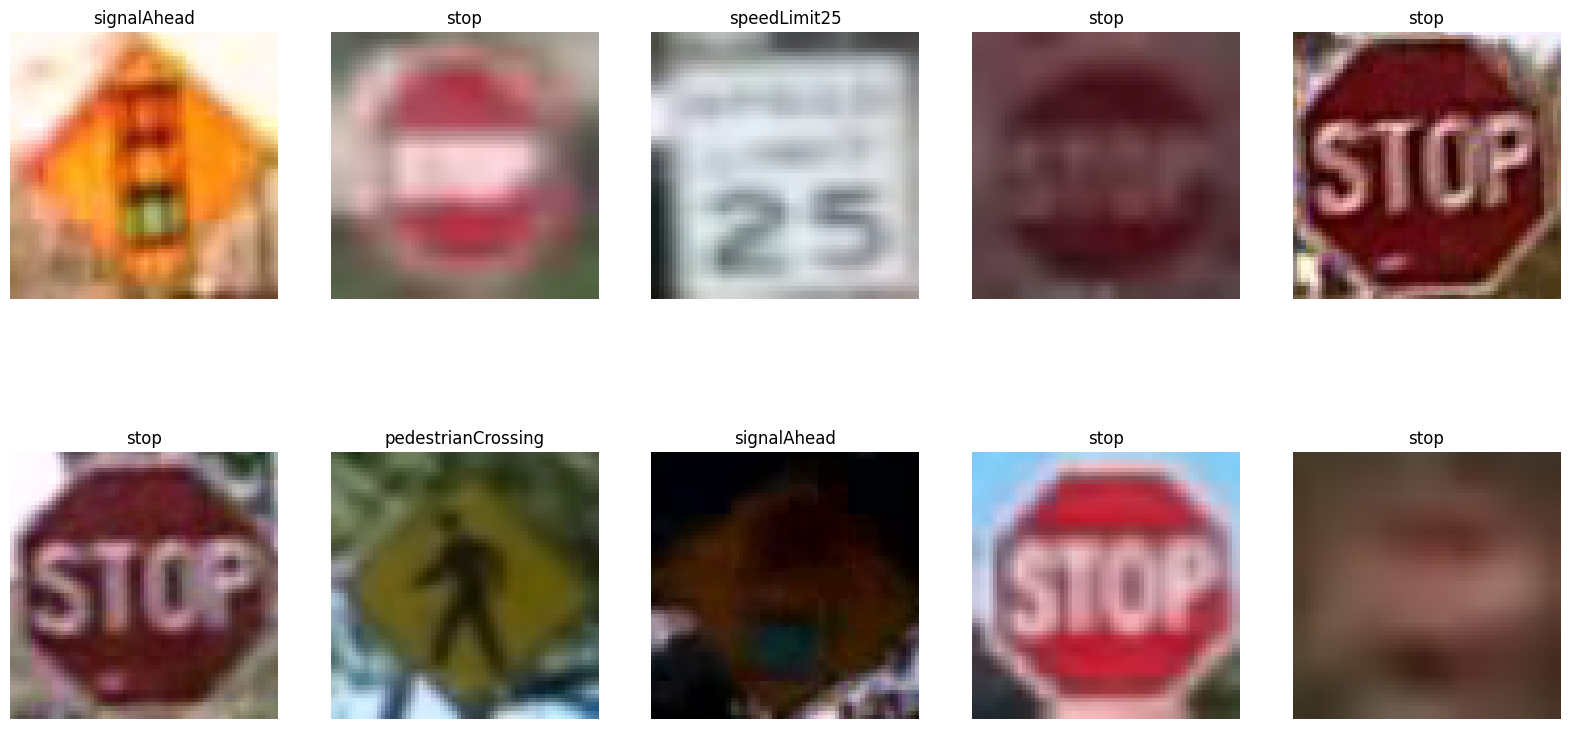

In [15]:
# Hiển thị các ảnh đã cắt và resize
def display_cropped_images(images, labels, class_mapping, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(class_mapping[labels[i]])
        plt.axis('off')
    plt.show()

# Hiển thị 10 ảnh đầu tiên
display_cropped_images(data, labels, class_mapping, num_images=10)

In [16]:
#Trích xuất đặc trưng HOG từ ảnh
hog_images = []
hog_features = []

for image in data:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    hog_features.append(fd)
    hog_images.append(hog_image)

hog_features = np.array(hog_features)
hog_images = np.array(hog_images)

In [17]:
def display_hog_images(images, titles):
    n = len(images)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 15))

    for i in range(n):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

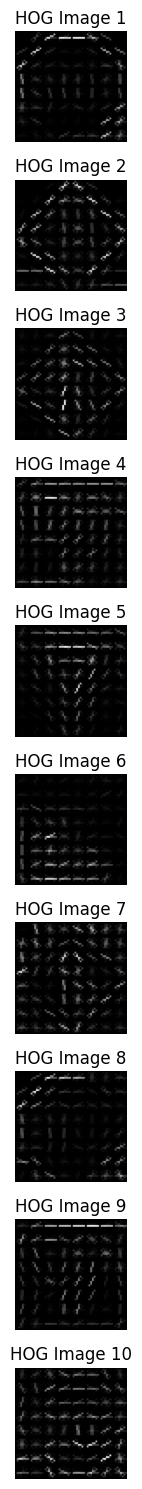

In [18]:
indices = np.random.choice(range(len(hog_images)), size=10, replace=False)
selected_hog_images = hog_images[indices]
titles = ['HOG Image {}'.format(i+1) for i in range(len(selected_hog_images))]

display_hog_images(selected_hog_images, titles)

In [19]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

In [20]:
# Huấn luyện mô hình SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [21]:
# Dự đoán và đánh giá mô hình
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        50
           2       0.93      1.00      0.96        13
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        19
           5       1.00      0.95      0.98        21
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        11

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Accuracy: 0.9944444444444445


In [22]:
# Huấn luyện mô hình KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
# Dự đoán và đánh giá mô hình
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.98      0.99        50
           2       1.00      0.92      0.96        13
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        19
           5       0.95      1.00      0.98        21
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        11

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Accuracy: 0.9888888888888889


In [24]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    boxes = np.array(boxes)
    pick = []
    
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / area[idxs[:last]]
        
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    
    return boxes[pick].astype("int")

def detect_and_predict_signs(image, model, class_mapping, window_size=(64, 64), step_size=32, confidence_threshold=0.7):
    detections = []
    
    for (x, y, window) in sliding_window(image, step_size=step_size, window_size=window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue
        
        gray_window = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
        fd, _ = hog(gray_window, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)
        
        prediction = model.predict([fd])[0]
        probabilities = model.predict_proba([fd])[0]
        confidence = probabilities[prediction]
        
        if confidence > confidence_threshold:
            detections.append([x, y, x + window_size[0], y + window_size[1], confidence, prediction])
    
    detections = non_max_suppression(np.array(detections), 0.3)
    
    for (x1, y1, x2, y2, confidence, class_id) in detections:
        predicted_class = class_mapping[class_id]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{predicted_class}: {confidence:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image


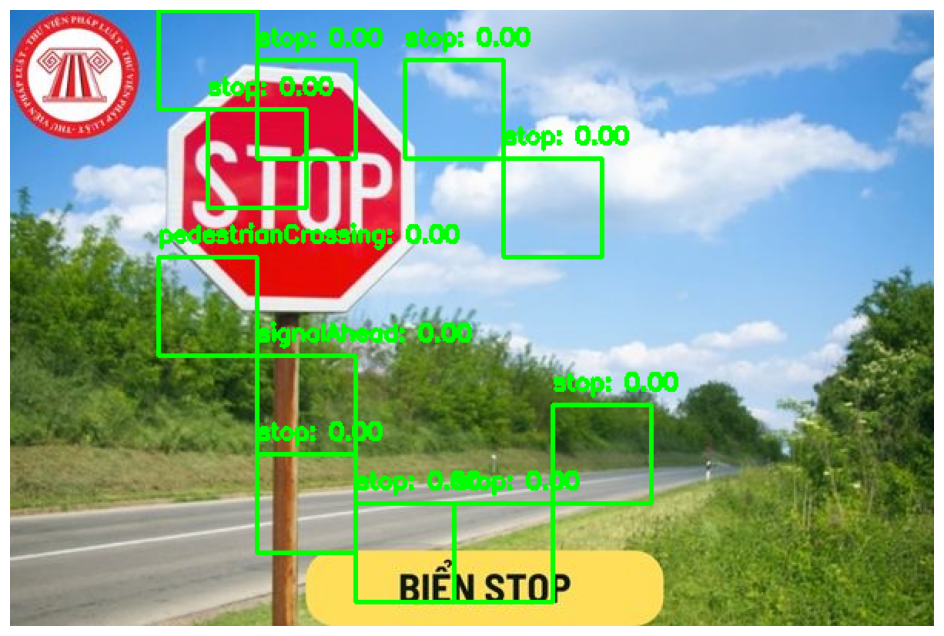

In [25]:
test_image_path = "D:/Study/Summer 2024/AIL303m/mini project/bien-stop.jpg"  # Thay thế bằng đường dẫn thực tế
test_image = cv2.imread(test_image_path)

result_image = detect_and_predict_signs(test_image, svm, class_mapping)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()